In [1]:
import sys

In [2]:
cd '/srv/flash1/hagrawal9/project/habitat/habitat-api/'

/coc/testnvme/hagrawal9/project/habitat/habitat-api


In [3]:
import io
import base64
import imageio
import gzip
import json
import json_tricks
import os
import sys
from typing import Any, Dict, List, Optional, Type

import attr
import cv2
import git
import magnum as mn
import numpy as np

# %matplotlib inline
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image


import habitat
import habitat_sim

from rearrangement.task.sensors import *

from habitat.config import Config
from habitat.core.registry import registry
from habitat_sim.utils import viz_utils as vut
from habitat.utils.visualizations import maps
from habitat.utils.visualizations.utils import observations_to_image

from habitat_sim.physics import MotionType
from habitat_sim.utils.viz_utils import is_notebook, display_video, get_fast_video_writer

In [4]:
from habitat.datasets.rearrangement.rearrangement_dataset import RearrangementDatasetV0
from habitat.tasks.rearrangement.rearrangement_task import RearrangementEpisode

In [89]:
p = 'data/new_checkpoints/b9KSrZfBpB5WC5gcCUtmMX/replays/l2dist_object/7TpTcJpBKNwUKkExzbUUjj'
# data/new_checkpoints/b9KSrZfBpB5WC5gcCUtmMX/videos/map_object/dPKBtXvPV6S2RyA8HVckGZ
files = os.listdir(p)
j = 0

In [92]:

for i, file in enumerate(files[j:]):
    with open(os.path.join(p, file), 'r') as f:
        data = json_tricks.load(f)
        # print(data['info'])
        if not data['info']['episode_success']:
            j += i+1
            break

In [93]:
print(i, file)

0 replays_7TpTcJpBKNwUKkExzbUUjj_0_Kemblesville.glb.json


In [94]:
eid = data['episode_id']
scene_id = data['scene_id']

In [95]:
eid

'0'

In [96]:
config = habitat.get_config("configs/tasks/rearrangement_gibson.yaml")

In [97]:
scene_id

'data/scene_datasets/gibson_train_val/Kemblesville.glb'

In [98]:
config.defrost()
config.DATASET.SPLIT = "val"
config.DATASET.CONTENT_SCENES = [f"rearrangement_hard_v7_{config.DATASET.SPLIT}_n=100_o=5_t=0.95_{scene_id.split('/')[-1].split('.')[0]}"]
config.TASK.MEASUREMENTS = ['OBJECT_TO_GOAL_DISTANCE', 'AGENT_TO_OBJECT_DISTANCE', 'EOR_TOP_DOWN_MAP']
config.freeze()

In [99]:
config.defrost()
config.SIMULATOR.DEPTH_SENSOR.HEIGHT = 512
config.SIMULATOR.DEPTH_SENSOR.WIDTH = 512
config.SIMULATOR.RGB_SENSOR.HEIGHT = 512
config.SIMULATOR.RGB_SENSOR.WIDTH = 512
config.SIMULATOR.CROSSHAIR_POS = [256, 384]
print(config.TASK.EOR_TOP_DOWN_MAP)
config.freeze()

DRAW_BORDER: True
DRAW_GOAL_AABBS: True
DRAW_GOAL_POSITIONS: True
DRAW_SHORTEST_PATH: True
DRAW_SOURCE: True
DRAW_VIEW_POINTS: True
FOG_OF_WAR:
  DRAW: True
  FOV: 90
  VISIBILITY_DIST: 5.0
MAP_PADDING: 3
MAP_RESOLUTION: 256
MAX_EPISODE_STEPS: 1000
TYPE: RearrangementTopDownMap


In [100]:
def print_info(obs, metrics):
    print(
        "Gripped Object: {}, Distance To Object: {}, Distance To Goal: {}".format(
            obs["gripped_object_id"],
            metrics["agent_to_object_distance"],
            metrics["object_to_goal_distance"],
        )
    )

In [101]:
try:
    env.close()
except:
    pass
env = habitat.Env(config)

2020-11-13 12:17:02,044 Initializing dataset RearrangementDataset-v0
2020-11-13 12:17:02,068 initializing sim RearrangementSim-v0
I1113 12:17:07.027588 37511 simulator.py:168] Loaded navmesh data/scene_datasets/gibson_train_val/Kemblesville.navmesh
I1113 12:17:07.028856 37511 simulator.py:180] Recomputing navmesh for agent's height 0.88 and radius 0.18.
2020-11-13 12:17:07,129 Initializing task RearrangementTask-v0


In [102]:
for ep in env.episodes:
    if ep.episode_id == eid:
        break

In [103]:
env._current_episode = ep

In [104]:
env._reset_stats()

if env._current_episode is not None:
    env._current_episode._shortest_path_cache = None
env.reconfigure(env._config)
obs = env.task.reset(episode=env.current_episode)
env._task.measurements.reset_measures(
    episode=env.current_episode, task=env.task
)
metrics = env.get_metrics()

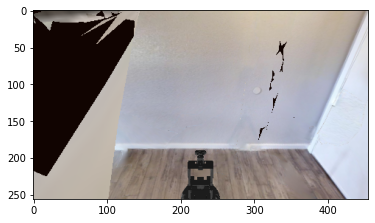

In [105]:
plt.imshow(obs['rgb_3rd_person'])

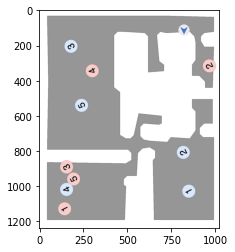

In [106]:
top_down_map = maps.get_topdown_map(
    env._task._simple_pathfinder,
    env._sim.get_agent(0).state.position[1],
    1024
)

top_down_map = maps.colorize_topdown_map(top_down_map)
agent_position = env._sim.get_agent_state().position
a_x, a_y = maps.to_grid(
    agent_position[2],
    agent_position[0],
    top_down_map.shape[0:2],
    sim=env._sim,
)

episode = env.current_episode
object_positions = [obj.position for obj in episode.objects]
goal_positions = [obj.position for obj in episode.goals]

grid_object_positions = []
grid_goal_positions = []

for i, obj_pos in enumerate(object_positions):
    tdm_pos = maps.to_grid(
        obj_pos[2],
        obj_pos[0],
        top_down_map.shape[0:2],
        sim=env._sim,
    )
    grid_object_positions.append(tdm_pos)

# draw the objectgoal positions.
for i, goal_pos in enumerate(goal_positions):
    tdm_pos = maps.to_grid(
        goal_pos[2],
        goal_pos[0],
        top_down_map.shape[0:2],
        sim=env._sim,
    )

    grid_goal_positions.append(tdm_pos)
    
grid_current_positions = [None] * len(object_positions)
for sim_obj_id in env._sim.get_existing_object_ids():
    if sim_obj_id != env._task.agent_object_id:
        obj_id = env._task.sim_object_to_objid_mapping[sim_obj_id]
        position = env._sim.get_translation(sim_obj_id)
        curr_pos = maps.to_grid(position[2], position[0], top_down_map.shape[0:2], sim=env._sim)
        grid_current_positions[obj_id] = curr_pos

    
top_down_map = maps.draw_agent(
    image=top_down_map,
    agent_center_coord=[a_x, a_y],
    agent_rotation=0,
    agent_radius_px=min(top_down_map.shape[0:2]) / 32,
)

top_down_map = maps.draw_object_info(top_down_map, grid_goal_positions, suffix='g')
top_down_map = maps.draw_object_info(top_down_map, grid_current_positions, suffix='c')

plt.imshow(top_down_map)
plt.savefig('top_down_map_illustration.png')

In [83]:
def restore_state(replay, env):
    for sim_obj_id, obj_id in replay['sim_object_id_to_objid_mapping'].items(): 
        curr_sim_obj_id = env._task.objid_to_sim_object_mapping[obj_id]
        env._sim.set_object_motion_type(
            MotionType.KINEMATIC, curr_sim_obj_id
        )
        env._sim.set_translation(replay['current_position'][sim_obj_id], curr_sim_obj_id)
        env._sim.set_object_motion_type(
            MotionType.STATIC, curr_sim_obj_id
        )
        agent_cfg = env._sim._get_agent_config(0)
        env._sim.set_agent_state(
            replay['agent_pos'],
            agent_cfg.START_ROTATION,
            0,
        )
        env._sim.set_translation(replay['agent_pos'], env._task.agent_object_id)
        

        print(sim_obj_id, obj_id, curr_sim_obj_id)
    env._task.measurements.update_measures(
        episode=env.current_episode, action=0, task=env.task
    )

In [60]:
restore_state(data, env)

1 0 1
2 1 2
3 2 3
4 3 4
5 4 5


In [76]:
for obj_id, goal in enumerate(env.current_episode.goals):

    agent_state = env._sim.get_agent_state()
    agent_position = agent_state.position
    sim_obj_id = env._task.objid_to_sim_object_mapping[obj_id]
    previous_position = np.array(
        env._sim.get_translation(sim_obj_id)
    ).tolist()

    goal_position = env.current_episode.goals[obj_id].position
    previous_position[1] = agent_position[1]
 
    d = geodesic_distance(
        env._sim.pathfinder, previous_position, agent_position
    )
    print(obj_id, d)

IndexError: list index out of range

In [107]:
def depth_to_rgb(depth_image: np.ndarray, clip_max: float = 10.0) -> np.ndarray:
    """Normalize depth image into [0, 1] and convert to grayscale rgb
    :param depth_image: Raw depth observation image from sensor output.
    :param clip_max: Max depth distance for clipping and normalization.
    :return: Clipped grayscale depth image data.
    """
    d_im = np.clip(depth_image, 0, clip_max)
    d_im /= clip_max
    # d_im = np.stack([d_im for _ in range(3)], axis=2)
    rgb_d_im = (d_im * 255).astype(np.uint8)
    return rgb_d_im

In [108]:
def render_frame(obs, info):
    img_frame = Image.fromarray(obs['rgb_3rd_person'])
    rgb = Image.fromarray(obs['rgb'])
    
    if "depth" in obs:
        d_im = depth_to_rgb(obs['depth'], clip_max=1.0)[:, :, 0]
        depth_map = np.stack([d_im for _ in range(3)], axis=2)

        depth = Image.fromarray(
            depth_map
        )


    overlay_rgb_img = rgb.resize((64, 64))
    overlay_depth_img = depth.resize((64, 64))

    img_frame.paste(overlay_rgb_img, box=(32, 32))
    img_frame.paste(overlay_depth_img, box=(32, 100))
    img_frame = np.array(img_frame)
    
    top_down_map = maps.colorize_draw_agent_and_fit_to_height(
            info["top_down_map"], img_frame.shape[0]
        )
    img_frame = np.concatenate((img_frame, top_down_map), axis=1)
    return img_frame

In [109]:
frames = []
for action in data['actions']:
    obs = env.step(action['action'])
    metrics = env.get_metrics()
    img_frame = render_frame(obs, metrics)
    frames.append(img_frame)
#     plt.imshow(obs['rgb_3rd_person'])
#     plt.title(action)
#     plt.show()

In [110]:
writer = get_fast_video_writer('data/2.mp4', fps=10)

for image_frame in frames:
    writer.append_data(np.array(image_frame))

writer.close()

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (764, 256) to (768, 256) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [111]:
display_video('data/2.mp4')